## Imports

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_model_optimization as tfmot

https://www.youtube.com/watch?v=pBOfQTfDMVg&ab_channel=BinaryStudy
https://www.cs.toronto.edu/~kriz/cifar.html
^CIFAR-10 stuff

## CIFAR-10 Loading

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def load_cifar10():
    x_train = y_train = np.array([])
    for i in range(1,6):
        dict = unpickle('CIFAR-10/data_batch_'+str(i))
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(len(data), 3,32,32).transpose(0,2,3,1)
        labels = np.array(labels).reshape(len(labels),1)
        if x_train.size==0:
            x_train = data
            y_train = labels
        else:
            x_train = np.concatenate((x_train,data),axis=0)
            y_train = np.concatenate((y_train,labels),axis=0)
    dict = unpickle('CIFAR-10/test_batch')
    data = dict[b'data']
    labels = dict[b'labels']
    x_test = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
    y_test = np.array(labels).reshape(len(labels),1)
    return (x_train, y_train), (x_test,y_test)
    
(x_train, y_train), (x_test,y_test) = load_cifar10()


## Data visualization

In [6]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def plot_sample(x,y,index):
    plt.figure(figsize=(15,2))
    plt.imshow(x[index])
    plt.xlabel(classes[y[index][0]])

# plot_sample(x_train,y_train,0)
# columns = 5
# rows = 4
# fig = plt.figure(figsize=(8,8))
# for i in range(1,columns*rows+1):
#     fig.add_subplot(rows,columns,i)
#     plt.imshow(x_test[i])
# plt.show()

### Normalize Data

In [7]:
x_train = x_train/255
x_test = x_test/255
x_train.shape

(50000, 32, 32, 3)

### Model

In [8]:
#Lenet-5 model on CIFAR10
model = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=5,  activation = 'relu', input_shape=(32,32,3),padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=16, kernel_size=5,  activation = 'relu',padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=120, kernel_size=5,  activation = 'relu',padding='valid'),
    layers.Flatten(),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-06-26 17:20:25.298331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-26 17:20:25.303373: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-26 17:20:25.303412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d-5-3-4): /proc/driver/nvidia/version does not exist
2023-06-26 17:20:25.315413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 480)               0

In [13]:
epochs = 10
history = model.fit(x_train,y_train,epochs=epochs, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7347 - accuracy: 0.7377 - val_loss: 1.0171 - val_accuracy: 0.6602
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.7032 - accuracy: 0.7514 - val_loss: 1.0488 - val_accuracy: 0.6536
Epoch 3/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6707 - accuracy: 0.7618 - val_loss: 1.0328 - val_accuracy: 0.6624
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6325 - accuracy: 0.7750 - val_loss: 1.1047 - val_accuracy: 0.6578
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6041 - accuracy: 0.7858 - val_loss: 1.0958 - val_accuracy: 0.6480
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5715 - accuracy: 0.7955 - val_loss: 1.1636 - val_accuracy: 0.6424
Epoch 7/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.5439 - accuracy: 0.8068 - val_loss: 1.2002 - val_accuracy:

## Plotting unpruned

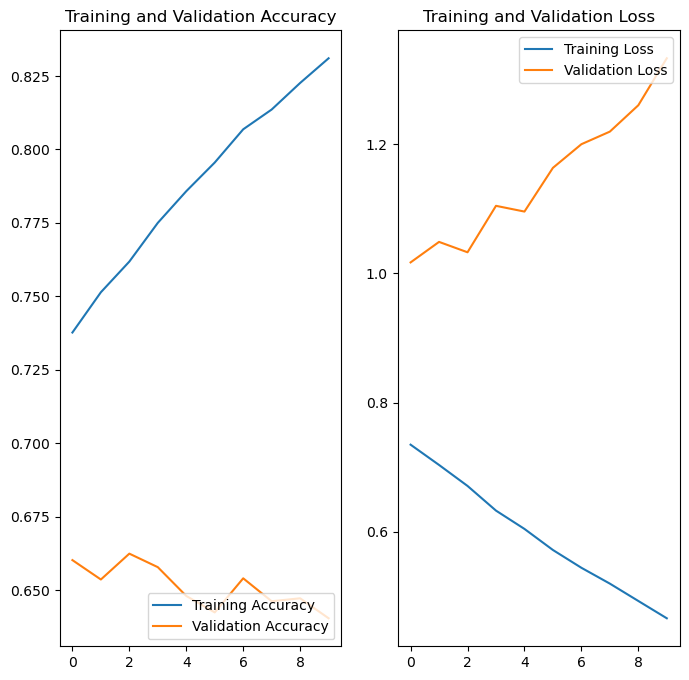

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing

In [16]:
test_loss, test_acc = model.evaluate(x_test,y_test)
print(test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 1.4209 - accuracy: 0.6259
0.6258999705314636


## Pruning

In [17]:
# Compute end step to finish pruning after 2 epochs.
epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.7,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_for_pruning.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 32, 32, 6)        908       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 16, 16, 6)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 12, 12, 16)       4818      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 6, 6, 16)       

### Pruning training

In [19]:
epochs = 10
history = model_for_pruning.fit(x_train, y_train,epochs=10,validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.4474 - accuracy: 0.8396 - val_loss: 1.3898 - val_accuracy: 0.6436
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.4144 - accuracy: 0.8502 - val_loss: 1.4554 - val_accuracy: 0.6430
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3986 - accuracy: 0.8556 - val_loss: 1.4999 - val_accuracy: 0.6324
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3769 - accuracy: 0.8654 - val_loss: 1.5415 - val_accuracy: 0.6410
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3530 - accuracy: 0.8747 - val_loss: 1.7374 - val_accuracy: 0.6148
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3351 - accuracy: 0.8789 - val_loss: 1.6879 - val_accuracy: 0.6364
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3140 - accuracy: 0.8858 - val_loss: 1.7575 - val_accuracy:

## Plotting pruned

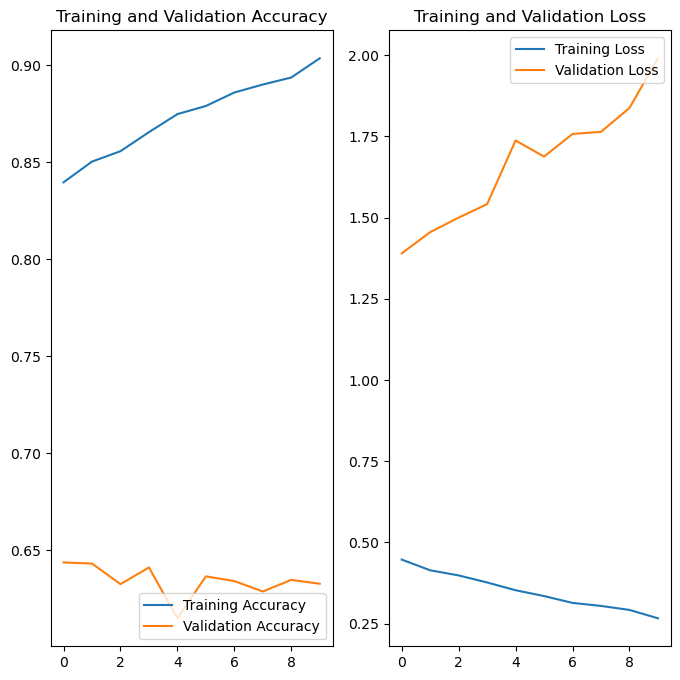

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
test_loss, test_acc = model_for_pruning.evaluate(x_test,y_test)
print(test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 2.0790 - accuracy: 0.6063
0.6062999963760376
